# Assignment 09

### 1.思考在自然语言处理中如何发掘模型的可解释性

应该要从构建可解释的模型、可视化和参数分析三个方面入手。对于NLP中容易出现对一词多义问题，在构建模型时可以先明确模型对应对领域，与应用场景产生关联；可视化和参数分析的工具比较多，比如RNN中的长距离时序关联刻画、对词向量的降维等。

### 2.在Seq2Seq和注意力机制中如何可视化模型细节

1.模型的组成部分：编码器和解码器之间的关联、每个编码器的构造（self-attention + forward）、每个解码器的构造（self-attention + attention + forward）

2.编码器（整体到局部、简单到复杂、局部到整体）

    1）编码器中的数据流动、编码的过程
    2）自注意力机制的计算过程（一维、二维），某一层中中词与词的映射
    3）多头（高维），多头下某一层中词与词的映射
    4）位置编码与词嵌入的联结
    5）层归一

3.解码器

    1）注意力层
    2）输出层

https://jalammar.github.io/illustrated-transformer/

### 3.对抗样本能否运用到自然语言处理模型中

在NLP任务中，对抗训练的角色不再是为了防御基于梯度的恶意攻击，反而更多的是作为一种regularization，提高模型的泛化能力。现在已经用到的对抗训练方法有Fast Gradient Method和Projected Gradient Descent。

### 4.复现Kaggle心脏病数据集冠军kernel，理解所用的模型可解释性技巧

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

Using TensorFlow backend.


In [2]:
dt = pd.read_csv("heart.csv")

In [3]:
dt.head(10)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   
5   56    1   2       120   236    0        0      178      0      0.8      1   
6   62    0   4       140   268    0        2      160      0      3.6      3   
7   57    0   4       120   354    0        0      163      1      0.6      1   
8   63    1   4       130   254    0        2      147      0      1.4      2   
9   53    1   4       140   203    1        2      155      1      3.1      3   

   ca  thal  target  
0   0     1       0  
1   3     2       1  
2   2     3       1  
3   0     2       0  
4   0     2       0  
5   0     2       0  
6   2     2       1  
7   0     2       0  
8   1     3       1  
9   0     3       1

#### 预处理

In [4]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [5]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [6]:
dt.describe(include=[np.object])

sex chest_pain_type  fasting_blood_sugar rest_ecg  \
count    303             303                  303      303   
unique     2               4                    2        3   
top     male    asymptomatic  lower than 120mg/ml   normal   
freq     206             144                  258      151   

       exercise_induced_angina   st_slope   thalassemia  
count                      303        303           303  
unique                       2          3             3  
top                         no  upsloping  fixed defect  
freq                       204        142           168

In [7]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [8]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [9]:
# 对特征进行Onehot编码，由（303，14）变成（303，19）
dt = pd.get_dummies(dt, drop_first=True)

In [10]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   67                     160          286                      108   
2   67                     120          229                      129   
3   37                     130          250                      187   
4   41                     130          204                      172   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       0         1   
1            1.5                  3       1         1   
2            2.6                  2       1         1   
3            3.5                  0       0         1   
4            1.4                  0       0         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 1   
4                                1                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               1                                        0   
1                               0                                        1   
2                               0                                        1   
3                               0                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      1                0   
1                                      1                0   
2                                      1                0   
3                                      0                1   
4                                      1                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            1              1                   0   
2                            1              1                   0   
3                            0              0                   0   
4                            0              0                   1   

   thalassemia_normal  thalassemia_reversable defect  
0                   1                              0  
1                   0                              0  
2                   0                              1  
3                   0                              0  
4                   0                              0

#### 建模

In [11]:
# drop：除了因变量都是自变量
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [12]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
estimator = model.estimators_[1]        # 选一个子分类器
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [14]:
# brew install graphviz，否则报错
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

#### 解释

In [15]:
y_predict = model.predict(X_test)                        
y_pred_quant = model.predict_proba(X_test)[:, 1]         # 返回每个类别的概率，类别的顺序和属性中相对应，这里选的是患病（1）的概率
y_pred_bin = model.predict(X_test)

混淆矩阵

In [16]:
# 按照Kaggle上面的写法，变量名和函数名相同，第二次运行时会报错
cf_matrix = confusion_matrix(y_test, y_pred_bin)        # rows: actual, col: predicted
cf_matrix

array([[26,  5],
       [ 5, 25]])

In [17]:
total=sum(sum(cf_matrix))

sensitivity = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0])        # TPR
print('Sensitivity : ', sensitivity )

specificity = cf_matrix[1,1]/(cf_matrix[1,1]+cf_matrix[0,1])        # TNR
print('Specificity : ', specificity)

Sensitivity :  0.8387096774193549
Specificity :  0.8333333333333334


ROC曲线：不同分类阈值情况下真正率（TPR）和假正率（FPR）的变化曲线

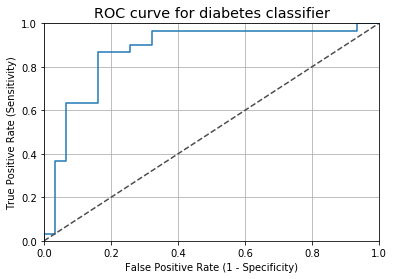

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [19]:
# ROC曲线和坐标轴围成的面积(AUC)越大，说明模型效果越好
auc(fpr, tpr)

0.8731182795698925

Permutation Importance：改变数据表格中某一列的数据的排列，保持其余特征不动，看其对预测精度的影响有多大

In [20]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

PDP：显示目标与特征之间的关系是线性的，单调的还是更复杂的

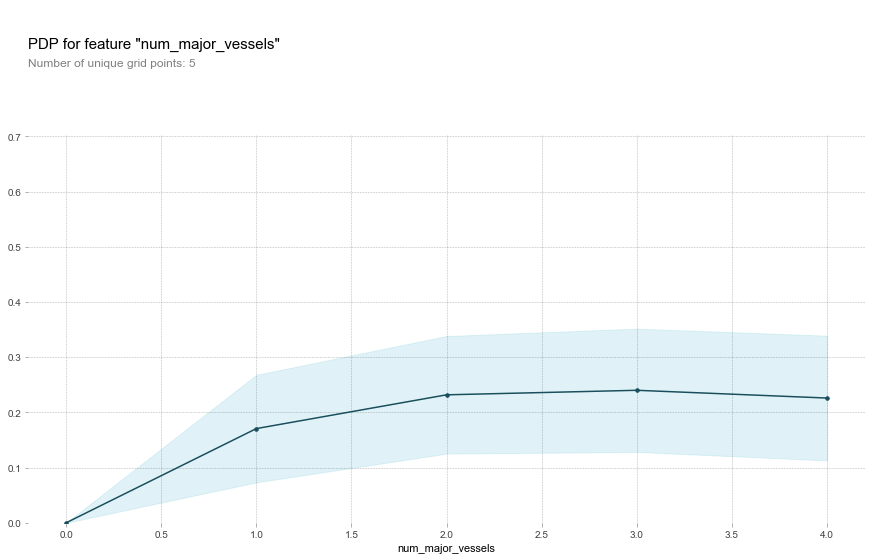

In [21]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

# num_major_vessels = 3 增加到一定数量时患病率不再增加

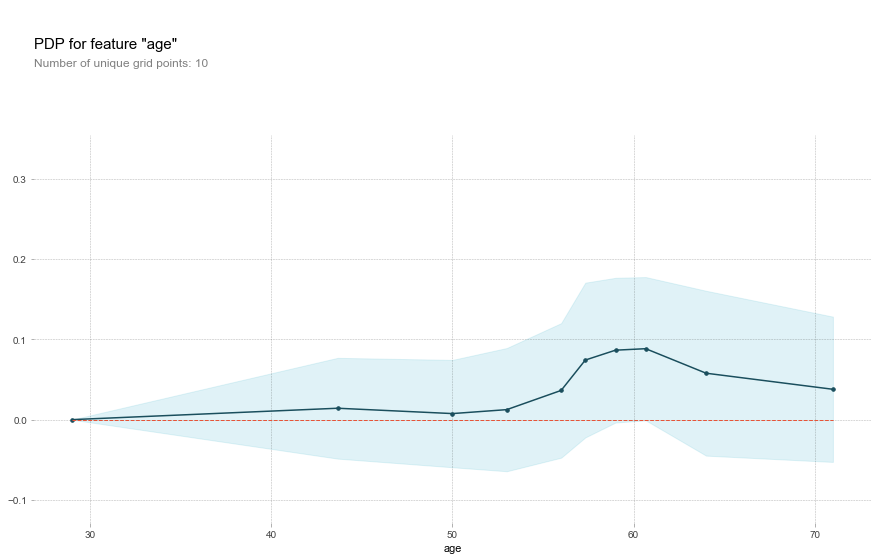

In [22]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

# 60岁之前年龄越大患心脏病概率越大，60岁之后反而降低

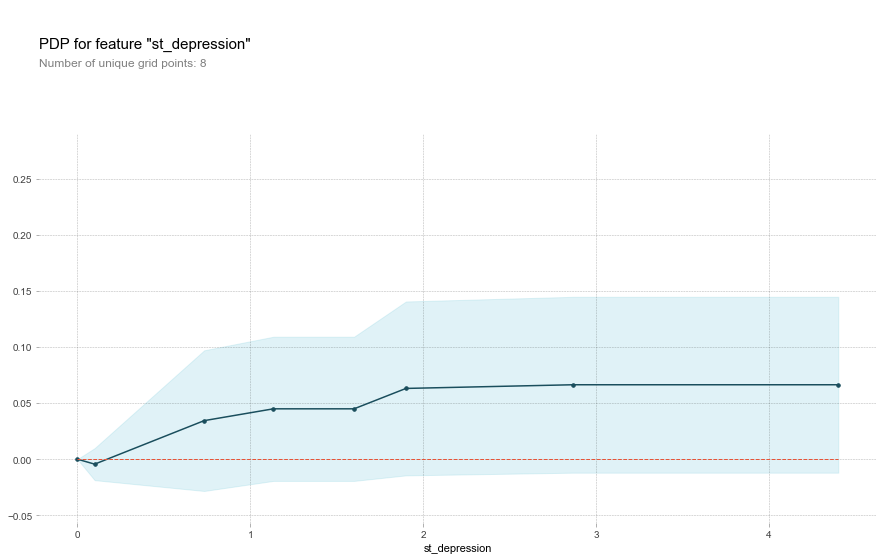

In [23]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

显示两个变量对因变量对关系

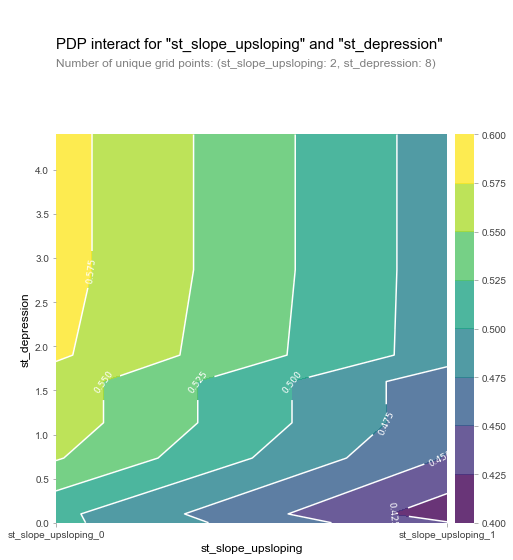

In [24]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

# 当st_depression > 2.7时，该指标对患病率几乎没有影响

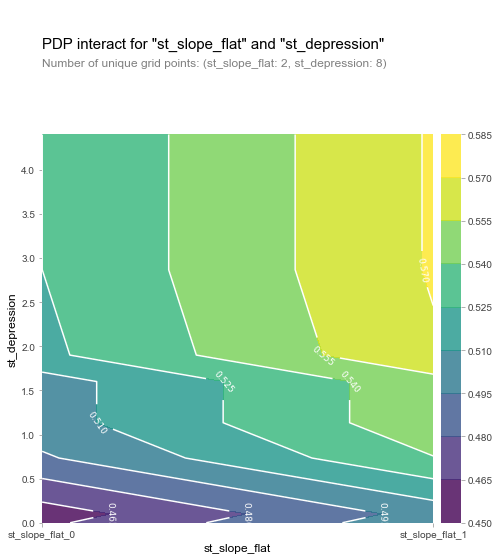

In [25]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

# st_depression对结果对影响更大

SHAP值：一个特征的shap value是该特征在所有的特征序列中的平均边际贡献

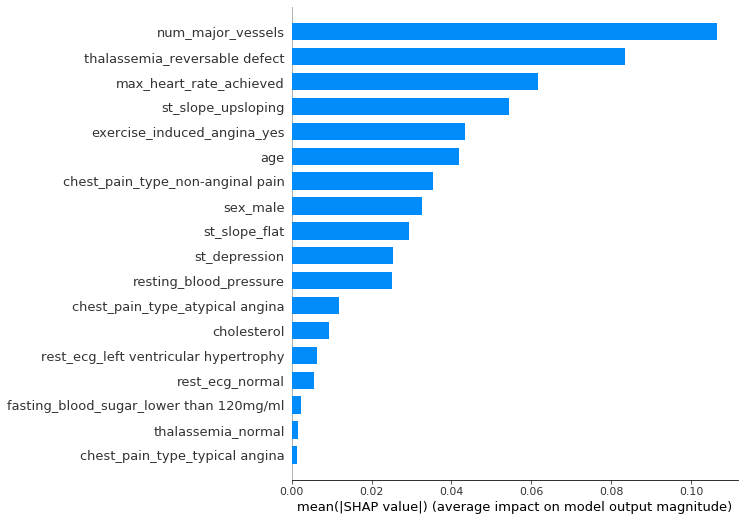

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

summary_plot

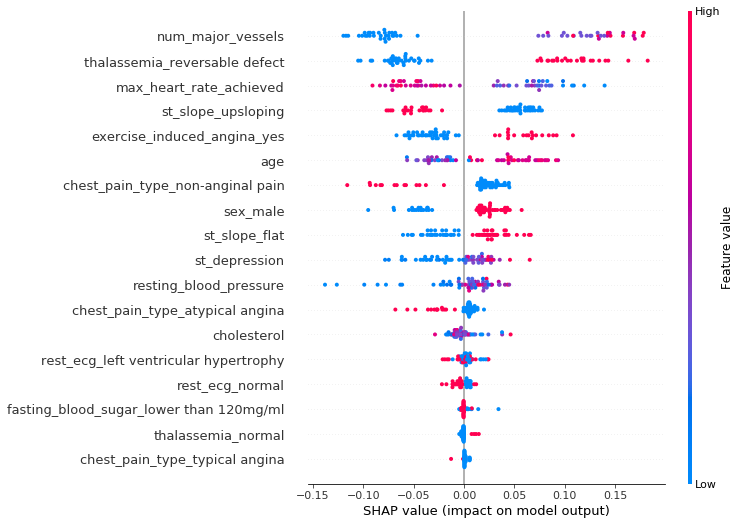

In [27]:
shap.summary_plot(shap_values[1], X_test)

# X轴：样本按Shap值排序，Y轴：特征按Shap值排序
# thal_defect几乎与结果正相关

In [28]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [29]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

# 将预测推高的特征用红色表示，将预测推低的特征用蓝色表示

In [30]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

dependence_plot：将该feature的SHAP值与数据集中所有样本的feature值进行比较。

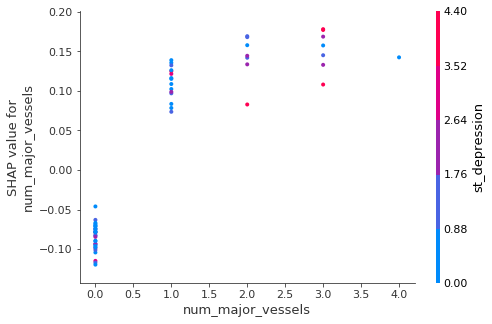

In [31]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

对多个样本对解释

In [32]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])